# CM4126 Coursework
## Alexandar Boyadzhiev 1906878

The objective of this project is to analyze chest X-ray images with the help of artificial intelligence (AI) to detect pneumonia. The project involves several key components, including research and data exploration, building a baseline model, and improving the model's performance through transfer learning and other techniques

# Research

Efficient Pneumonia Detection in Chest Xray Images Using Deep Transfer Learning
Mohammad Farukh Hashmi et al.
https://www.mdpi.com/2075-4418/10/6/417#sec3-diagnostics-10-00417


The paper proposes a deep transfer learning-based approach for the automatic detection of pneumonia in chest X-ray images. The proposed methodology consists of pre-processing the images and then training multiple deep learning models, including InceptionV3, ResNet50, and DenseNet121, using transfer learning techniques. The paper also proposes a weighted classifier to combine the different models to obtain better results. The proposed approach achieved an accuracy of 98.857%, a high F1 score of 99.002, and an AUC score of 99.809.

The paper addresses an important problem of pneumonia detection in chest X-ray images, which can aid in early diagnosis and treatment of the disease. The methodology proposed in the paper is well-researched, and the results obtained are promising. The use of multiple deep learning models and transfer learning techniques has helped in achieving high accuracy and robustness. The activation maps generated in the paper also show that the deep learning models were able to identify pneumonia-affected regions in the chest X-rays.

However, the paper also has some limitations. The scarcity of available data is one of the limitations. Deep learning models usually require a large amount of data for training to avoid overfitting and to improve their generalization ability. The variability in the chest X-ray data is several orders of magnitude smaller than that of large datasets like ImageNet, which can affect the performance of the models. Although data augmentation techniques were used to mitigate this problem, the performance of the proposed methodology could increase with the availability of more data.

Another limitation is the difficulty in interpreting the results of the deep learning models. The deep understanding of the radiological features visible in chest X-rays is required for the diagnosis of the disease from the X-rays, which may not always be feasible for non-experts. The proper explanation of the final prediction of the model is also required, and this is one of the drawbacks of the deep learning-based models. To this end, the activation maps were plotted, but further work is required.

In conclusion, the paper proposes a robust methodology for the automatic detection of pneumonia in chest X-ray images using deep transfer learning techniques. The proposed approach achieved high accuracy and robustness, which can aid in early diagnosis and treatment of the disease. However, the scarcity of available data and the difficulty in interpreting the results of the deep learning models are some of the limitations of the paper. In the future, it would be interesting to see approaches in which the weights corresponding to different models can be estimated more efficiently and a model that takes into account the patient’s history while making predictions

# Data Exploration

In [1]:
# import the required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image
from skimage import exposure
#pip install tensorflow-directml-plugin
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

Using Jupyter notebook and a local dataset to utilize own powerful GPU
Source: 
Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images
https://data.mendeley.com/datasets/rscbjbr9sj

In [2]:
dataPath = "C:/Users/amb20/Desktop/CellData/chest_xray"
print(os.listdir(dataPath))

['test', 'train']


In [3]:
train_folder_path = dataPath + '/train/'
test_folder_path = dataPath + '/test/'
val_folder_path = dataPath + '/val/'

Batch size of 16 chosen for highest AUC score considering learning rate and Adam clssifier

"The effect of batch size on the generalizability of the convolutional neural networks on a histopathology dataset" Ibrahem Kandel, Mauro Castelli 
https://www.sciencedirect.com/science/article/pii/S2405959519303455

In [4]:
labels = os.listdir(train_folder_path)
img_size = 112 # 
batch_size = 16
n_epochs = 100 
labels

['NORMAL', 'PNEUMONIA']

In [5]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'

test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

In [6]:
print(f'Number of normal images is {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of postive images is {len(os.listdir(train_p_path))}') #length of pneumonia training images 
print(f'Total training images is  {len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))}')

Number of normal images is 1349
Number of postive images is 3883
Total training images is  5232


In [7]:
print(f'Number of normal images is {len(os.listdir(test_n_path))}') 
print(f'Number of positive images is {len(os.listdir(test_p_path))}') 
print(f'Total training images is {len(os.listdir(test_n_path)) + len(os.listdir(test_p_path))}') 

Number of normal images is 234
Number of positive images is 390
Total training images is 624


In [8]:
def get_training_data(data_dir):
    data = [] # Create an empty list to store the training data
    for label in labels: # Loop through each label in the directory
        path = os.path.join(data_dir, label)# Construct the path to the label directory
        class_num = labels.index(label) # Get the index of the current label
        for img in os.listdir(path): # Loop through each image in the label directory
            try:
                img_arr = cv2.imread(os.path.join(path, img)) # Read the image file using OpenCV
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num]) # Add the image and its label to the training data list
            except Exception as e:
                print(e)
    return np.array(data)

In [9]:
train = get_training_data(train_folder_path)
temp = np.random.permutation(train) # Shuffle the data
train_size = 0.8 # Sets the split ratio

# Assigns 80% to training array and 20% to validation set
train, val = temp[:(int(train_size*len(temp)))], temp[int(train_size*len(temp)):]

In [10]:
# Load the datasets 
test = get_training_data(test_folder_path)

In [11]:
print(f'The shape of the training set is {train.shape}') 
print(f'The shape of the test set is {test.shape}') 
print(f'The shape of the val set is {val.shape}') 

The shape of the training set is (4185, 2)
The shape of the test set is (624, 2)
The shape of the val set is (1047, 2)


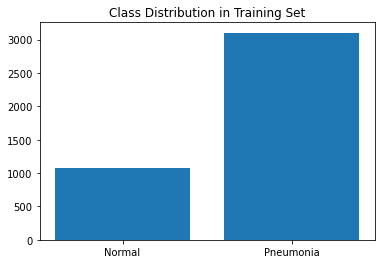

In [12]:
train_labels = np.array([label for _, label in train])

# Define class labels
class_labels = ['Normal', 'Pneumonia']

# Calculate class distribution
class_distribution = np.unique(train_labels, return_counts=True)

# Plot bar chart
plt.bar(class_labels, class_distribution[1])
plt.title('Class Distribution in Training Set')
plt.show()

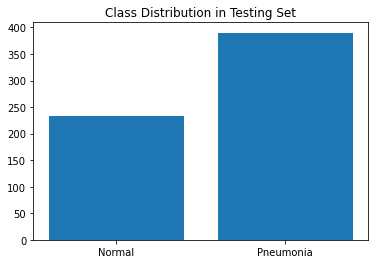

In [13]:
test_labels = np.array([label for _, label in test])

# Define class labels
class_labels = ['Normal', 'Pneumonia']

# Calculate class distribution
class_distribution = np.unique(test_labels, return_counts=True)

# Plot bar chart
plt.bar(class_labels, class_distribution[1])
plt.title('Class Distribution in Testing Set')
plt.show()

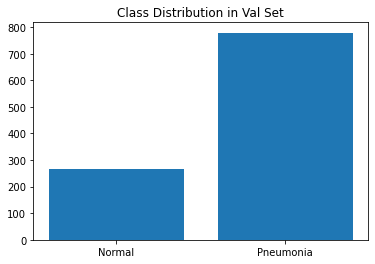

In [14]:
val_labels = np.array([label for _, label in val])

# Define class labels
class_labels = ['Normal', 'Pneumonia']

# Calculate class distribution
class_distribution = np.unique(val_labels, return_counts=True)

# Plot bar chart
plt.bar(class_labels, class_distribution[1])
plt.title('Class Distribution in Val Set')
plt.show()

In [15]:
def show_sample_images (number, normal=True):
    plt.figure(figsize=(12,12))
    if normal == True:
        for n in range(number):
            normal_img = os.listdir(train_n_path)[n]
            normal_img_address = train_n_path+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("NORMAL")
    else:
        for n in range(number):
            pneumonia_img =  os.listdir(train_p_path)[n]
            pneumonia_img_address = train_p_path+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            #cast nrows to integer
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("PNEUMONIA")
      
    plt.axis("off")  

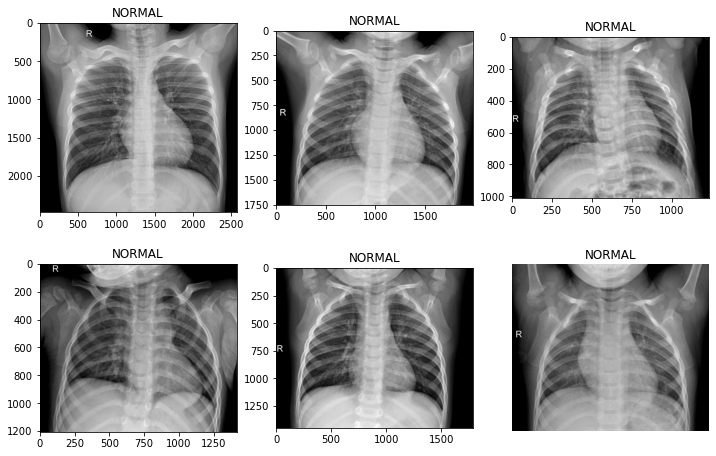

In [16]:
# Show normal images
numberImg= 6
show_sample_images(numberImg)

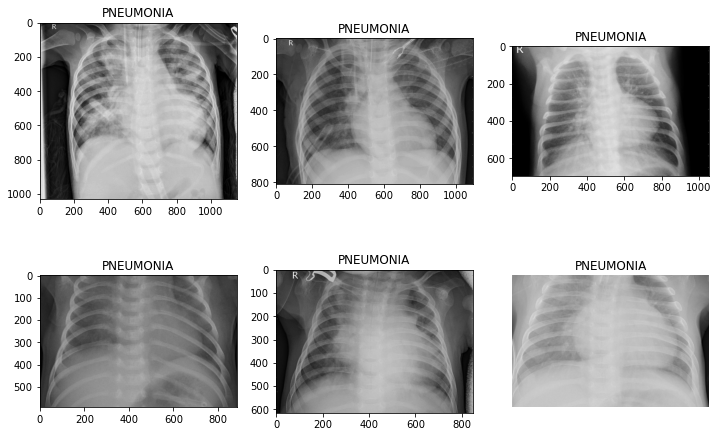

In [17]:
# show pneumonia images 
show_sample_images(6,False)

In [18]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [19]:
def expose_image(Normal=True):
    if Normal==True:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_n_path))) 
        # image file name 
        img_expose_name = os.listdir(train_n_path)[random_img_ind]

        # path to the image
        img_expose_address = train_n_path+img_expose_name

        # load mage 
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Normal')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Normal after HE')
        plt.axis("off") 
    else:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_p_path))) 
        # image file name 
        img_expose_name = os.listdir(train_p_path)[random_img_ind]

        # path to the image
        img_expose_address = train_p_path+img_expose_name

        # load mage 
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Pneumonia')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Pneumonia after HE')
        plt.axis("off") 

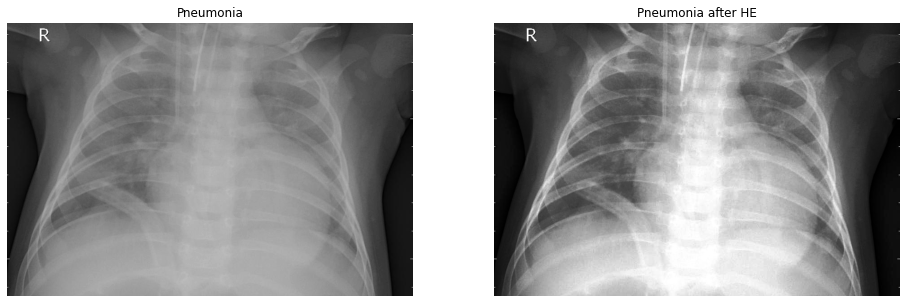

In [20]:
# expose_image() will show random normal image
expose_image(False)

In [21]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [22]:
print(f'Number of images in the training set is {len(x_train)}')

Number of images in the training set is 4185


In [23]:
# Normalise the data 

x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [24]:
# resize data for deep learning (img_size above is set to 244 by 244)
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

# Baseline model

Data augmentation is a technique that artificially increases the size of the training data by
applying random transformations to the input data. This can help improve accuracy 
while reducing overfitting, which can ultimately reduce training time.
"A survey on Image Data Augmentation for Deep Learning" Connor Shorten & Taghi M. Khoshgoftaar 
https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
datagen = ImageDataGenerator(

      featurewise_center=False, #feature-wise centering of the input data 
      samplewise_center=False, #sample-wise centering of the input data
      featurewise_std_normalization=False, #feature-wise standardization of the input data
      samplewise_std_normalization=False, #sample-wise standardization of the input data
      zca_whitening=False, #ZCA whitening of the input data
      
      #vertical_flip=True,  # randomly flip images horizontally
      rotation_range=10,  # randomly rotate images by 10 degrees
      width_shift_range=0.1,  # randomly shift images horizontally by 10%
      height_shift_range=0.1,  # randomly shift images vertically by 10%
      horizontal_flip=True,  # randomly flip images horizontally
      zoom_range=0.1,  # randomly zoom images by 10%
      fill_mode='nearest'  # fill any empty pixels with the nearest value
      ) 

datagen.fit(x_train)

Batch normalization is a technique used in neural networks to improve the training process by normalizing the input data to each layer. It helps to reduce the internal covariate shift problem and enables the use of higher learning rates, resulting in faster convergence and better accuracy.
https://research.google/pubs/pub43442/

Dropout is a regularization technique used in neural networks to prevent overfitting. During training, some neurons are randomly dropped out, which forces the network to learn more robust features and prevents it from relying too heavily on any single neuron. This helps to improve generalization performance on unseen data.
https://jmlr.org/papers/v15/srivastava14a.html

In [26]:
# Model setup
model = Sequential([
    Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),
    Conv2D(64, (3,3), strides=1, padding='same', activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),
    Conv2D(128, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),
    Conv2D(256, (3,3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),
    Conv2D(512, (3,3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2), strides=2, padding='same'),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
# model summary (see the number of trainable parameters)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 56, 56, 64)       2

In [28]:
total = len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))
neg = len(os.listdir(train_n_path))
pos = len(os.listdir(train_p_path))

weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.939214232765011, 1: 0.6737058975019315}

In [29]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', # Metric to monitor
    patience = 2, # Number of epochs to wait before updating
    verbose = 1, # Print message when early stopping is triggered
    factor = 0.3, # rate of reduction
    min_lr = 0.00001
)

Early stopping is a technique that stops training when the accuracy stops improving.
This can help reduce training time while maintaining accuracy.
https://paperswithcode.com/method/early-stopping

In [30]:
early_stop = EarlyStopping(
    monitor='accuracy', # Metric to monitor
    patience=10, # Number of epochs to wait before stopping
    mode='max', # Whether the monitored metric should be minimized or maximized
    verbose=1 # Print message when early stopping is triggered
)

In [31]:
# Start training the model
history = model.fit(datagen.flow
                    (x_train, y_train, batch_size = batch_size), 
                    epochs = n_epochs, 
                    validation_data = datagen.flow(x_val, y_val), 
                    callbacks = [learning_rate_reduction,early_stop],
                    verbose = 1,
                    class_weight = class_weight
                   )

Epoch 1/100
262/262 [==============================] - 10s 34ms/step - loss: 0.4350 - accuracy: 0.8583 - val_loss: 18.8425 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 2/100
262/262 [==============================] - 9s 33ms/step - loss: 0.2629 - accuracy: 0.9006 - val_loss: 3.8572 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 3/100
261/262 [============================>.] - ETA: 0s - loss: 0.2166 - accuracy: 0.9189
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [==============================] - 9s 33ms/step - loss: 0.2173 - accuracy: 0.9190 - val_loss: 0.8495 - val_accuracy: 0.4651 - lr: 0.0010
Epoch 4/100
262/262 [==============================] - 9s 33ms/step - loss: 0.1532 - accuracy: 0.9424 - val_loss: 0.3087 - val_accuracy: 0.8749 - lr: 3.0000e-04
Epoch 5/100
262/262 [==============================] - 9s 33ms/step - loss: 0.1438 - accuracy: 0.9493 - val_loss: 0.0994 - val_accuracy: 0.9656 - lr: 3.0000e-04
Epoch 6/100
262/262 [=======================

<AxesSubplot:>

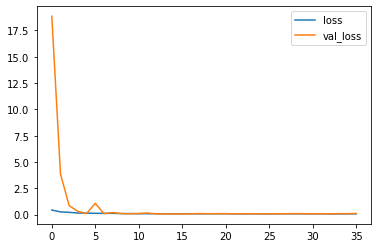

In [32]:
model.history.history
losses = pd.DataFrame(model.history.history)

losses[['loss','val_loss']].plot()

<AxesSubplot:>

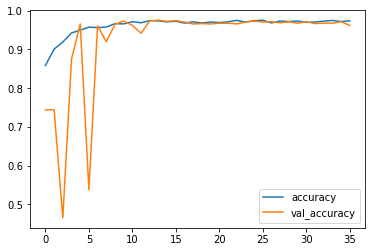

In [33]:
losses[['accuracy','val_accuracy']].plot()

In [34]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 8ms/step - loss: 0.1582 - accuracy: 0.9423
Loss of the model is -  0.15817338228225708
20/20 [==============================] - 0s 7ms/step - loss: 0.1582 - accuracy: 0.9423
Accuracy of the model is -  94.2307710647583 %


In [35]:
predictions=model.predict(x_test) 
pred_labels= np.where(predictions>0.5, 1, 0)

20/20 [==============================] - 0s 6ms/step


In [36]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.92      0.92       234
   Normal (Class 1)       0.95      0.95      0.95       390

           accuracy                           0.94       624
          macro avg       0.94      0.94      0.94       624
       weighted avg       0.94      0.94      0.94       624



<AxesSubplot:>

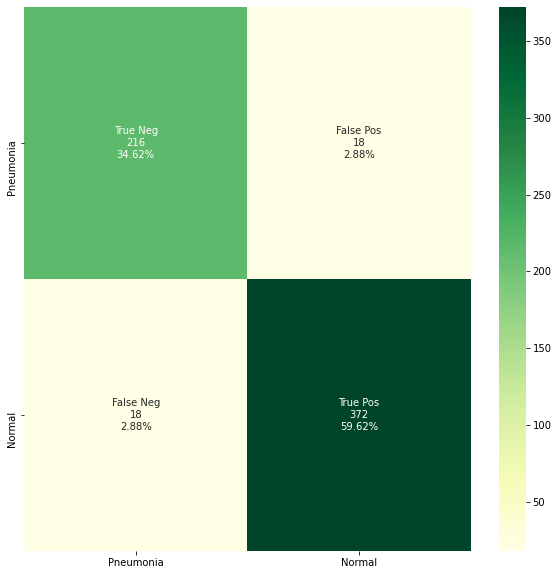

In [37]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [38]:
# store actual class labels and predicted ones in a dataframe

results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
15,0,1
22,0,1
43,0,1
45,0,1
46,0,1


In [39]:
# manual calculation of of results 
print(f'Accuracy is {round((results.shape[0]-incorrect_df.shape[0])/results.shape[0],2)*100} %')

Accuracy is 94.0 %


In [40]:
#show some examples
correct = np.nonzero(pred_labels == y_test)[0]
incorrect = np.nonzero(pred_labels != y_test)[0]

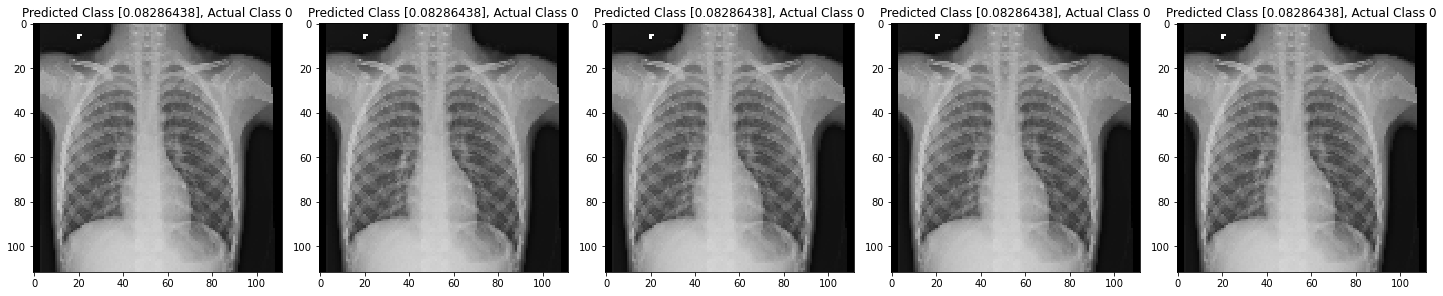

In [41]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

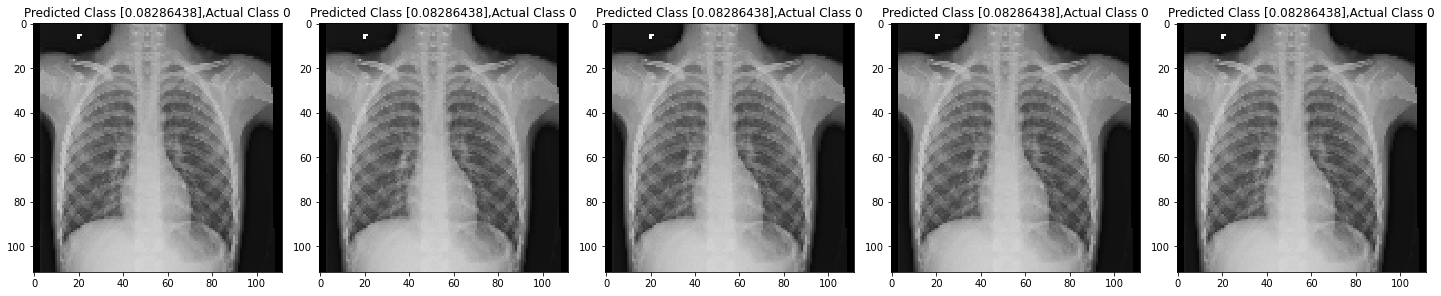

In [42]:
i = 0
figure = plt.figure(figsize= (20,20))
for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [43]:
#from keras.applications.vgg16 import VGG16

# Solution Improvement

## Two different transfer learning models considered based on accuracy in image recognition tasks

"Deep Feature-based Classifiers for Fruit Fly
Identification (Diptera: Tephritidae)" Matheus M. Leonardo et. al.
https://ieeexplore.ieee.org/document/8614309

In [44]:
tf.keras.backend.clear_session()

base_modelVG = tf.keras.applications.VGG16(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)

base_modelRes = tf.keras.applications.ResNet152V2(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
base_modelVG.trainable = False
base_modelRes.trainable = False

In [45]:
#different monitor needed to train these models
learning_rate_reduction_two = ReduceLROnPlateau(
    monitor = 'val_binary_accuracy', # Metric to monitor
    patience = 2, # Number of epochs to wait before updating
    verbose = 1, # Print message when early stopping is triggered
    factor = 0.3, # reduction factor
    min_lr = 0.000001
)

In [46]:
early_stop_two = EarlyStopping(
    monitor='binary_accuracy', # Metric to monitor
    patience=10, # Number of epochs to wait before stopping
    mode='max', # Whether the monitored metric should be minimized or maximized
    verbose=1 # Print message when early stopping is triggered
)

In [47]:
def get_pretrained(model):
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    
    x = model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    modelOut = tf.keras.Model(inputs=[inputs], outputs=output)
    
    return modelOut

In [52]:
model_pretrainedVG = get_pretrained(base_modelVG)
model_pretrainedVG.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005),
    metrics='binary_accuracy')

model_pretrainedRes = get_pretrained(base_modelRes)
model_pretrainedRes.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005),
    metrics='binary_accuracy')

model_pretrainedVG.summary()
model_pretrainedRes.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                           

In [53]:
history_tl = model_pretrainedVG.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction_two,early_stop_two],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )

Epoch 1/100
261/261 [==============================] - 9s 33ms/step - loss: 0.6769 - binary_accuracy: 0.6808 - val_loss: 0.5846 - val_binary_accuracy: 0.8329 - lr: 5.0000e-05
Epoch 2/100
261/261 [==============================] - 9s 34ms/step - loss: 0.5541 - binary_accuracy: 0.8060 - val_loss: 0.4952 - val_binary_accuracy: 0.8520 - lr: 5.0000e-05
Epoch 3/100
261/261 [==============================] - 9s 34ms/step - loss: 0.4743 - binary_accuracy: 0.8385 - val_loss: 0.4357 - val_binary_accuracy: 0.8653 - lr: 5.0000e-05
Epoch 4/100
261/261 [==============================] - 9s 35ms/step - loss: 0.4163 - binary_accuracy: 0.8554 - val_loss: 0.3796 - val_binary_accuracy: 0.8730 - lr: 5.0000e-05
Epoch 5/100
261/261 [==============================] - 9s 36ms/step - loss: 0.3776 - binary_accuracy: 0.8652 - val_loss: 0.3541 - val_binary_accuracy: 0.8854 - lr: 5.0000e-05
Epoch 6/100
261/261 [==============================] - 9s 35ms/step - loss: 0.3579 - binary_accuracy: 0.8645 - val_loss: 0.31

In [54]:
history_tl = model_pretrainedRes.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction_two,early_stop_two],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )

Epoch 1/100
261/261 [==============================] - 23s 61ms/step - loss: 0.3956 - binary_accuracy: 0.8270 - val_loss: 0.2559 - val_binary_accuracy: 0.8921 - lr: 5.0000e-05
Epoch 2/100
261/261 [==============================] - 13s 51ms/step - loss: 0.2573 - binary_accuracy: 0.8910 - val_loss: 0.2106 - val_binary_accuracy: 0.9198 - lr: 5.0000e-05
Epoch 3/100
261/261 [==============================] - 13s 50ms/step - loss: 0.2220 - binary_accuracy: 0.9087 - val_loss: 0.1602 - val_binary_accuracy: 0.9351 - lr: 5.0000e-05
Epoch 4/100
261/261 [==============================] - 12s 47ms/step - loss: 0.2050 - binary_accuracy: 0.9161 - val_loss: 0.1816 - val_binary_accuracy: 0.9370 - lr: 5.0000e-05
Epoch 5/100
261/261 [==============================] - 12s 47ms/step - loss: 0.1991 - binary_accuracy: 0.9185 - val_loss: 0.2056 - val_binary_accuracy: 0.9093 - lr: 5.0000e-05
Epoch 6/100
262/261 [==============================] - ETA: 0s - loss: 0.2066 - binary_accuracy: 0.9159
Epoch 6: ReduceL

261/261 [==============================] - 13s 49ms/step - loss: 0.1589 - binary_accuracy: 0.9355 - val_loss: 0.1357 - val_binary_accuracy: 0.9494 - lr: 1.0000e-05
Epoch 46/100
261/261 [==============================] - 13s 49ms/step - loss: 0.1476 - binary_accuracy: 0.9410 - val_loss: 0.1174 - val_binary_accuracy: 0.9570 - lr: 1.0000e-05
Epoch 47/100
261/261 [==============================] - 13s 51ms/step - loss: 0.1555 - binary_accuracy: 0.9384 - val_loss: 0.1477 - val_binary_accuracy: 0.9456 - lr: 1.0000e-05
Epoch 48/100
261/261 [==============================] - 13s 48ms/step - loss: 0.1588 - binary_accuracy: 0.9379 - val_loss: 0.1216 - val_binary_accuracy: 0.9475 - lr: 1.0000e-05
Epoch 49/100
261/261 [==============================] - 13s 48ms/step - loss: 0.1573 - binary_accuracy: 0.9412 - val_loss: 0.1341 - val_binary_accuracy: 0.9465 - lr: 1.0000e-05
Epoch 50/100
261/261 [==============================] - 13s 51ms/step - loss: 0.1450 - binary_accuracy: 0.9405 - val_loss: 0.121

<AxesSubplot:>

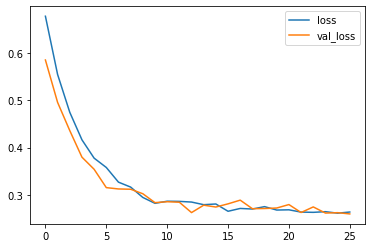

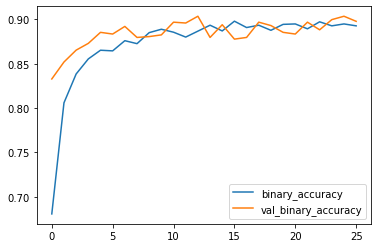

In [55]:
lossesVG = pd.DataFrame(model_pretrainedVG.history.history)
lossesVG[['loss','val_loss']].plot()
lossesVG[['binary_accuracy','val_binary_accuracy']].plot()

<AxesSubplot:>

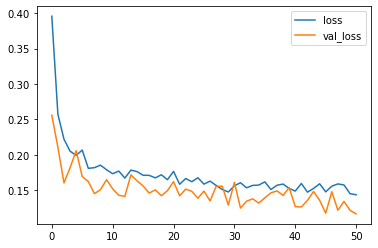

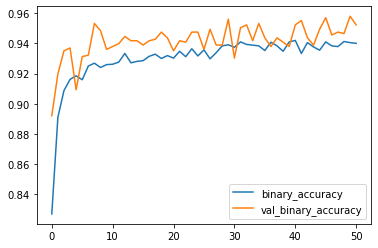

In [56]:
lossesRes = pd.DataFrame(model_pretrainedRes.history.history)
lossesRes[['loss','val_loss']].plot()
lossesRes[['binary_accuracy','val_binary_accuracy']].plot()

In [57]:
print("Loss of the VG model is - " , model_pretrainedVG.evaluate(x_test,y_test)[0])
print("Accuracy of VG the model is - " , model_pretrainedVG.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 40ms/step - loss: 0.3114 - binary_accuracy: 0.8702
Loss of the VG model is -  0.31136220693588257
20/20 [==============================] - 1s 39ms/step - loss: 0.3114 - binary_accuracy: 0.8702
Accuracy of VG the model is -  87.0192289352417 %


In [58]:
print("Loss of the Res model is - " , model_pretrainedRes.evaluate(x_test,y_test)[0])
print("Accuracy of Res the model is - " , model_pretrainedRes.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 54ms/step - loss: 0.1906 - binary_accuracy: 0.9279
Loss of the Res model is -  0.19063031673431396
20/20 [==============================] - 1s 60ms/step - loss: 0.1906 - binary_accuracy: 0.9279
Accuracy of Res the model is -  92.78846383094788 %


In [59]:
predictionsVG = model_pretrainedVG.predict(x_test)
pred_labelsVG= np.where(predictionsVG>0.5, 1, 0)

predictionsRes = model_pretrainedRes.predict(x_test)
pred_labelsRes= np.where(predictionsRes>0.5, 1, 0)

20/20 [==============================] - 4s 57ms/step


<AxesSubplot:>

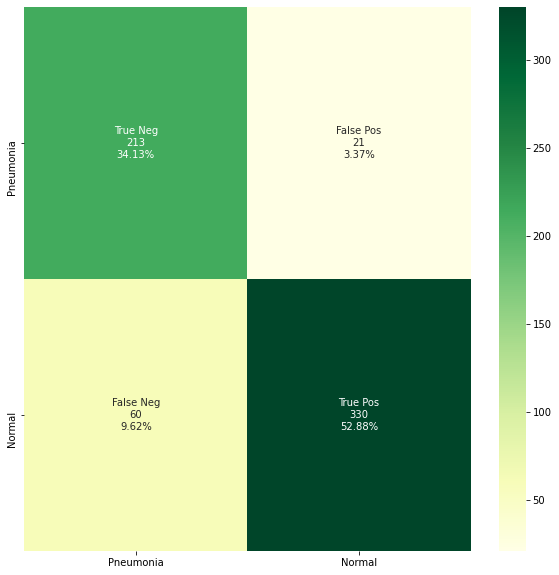

In [60]:
cf_matrix = confusion_matrix(y_test, pred_labelsVG)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

<AxesSubplot:>

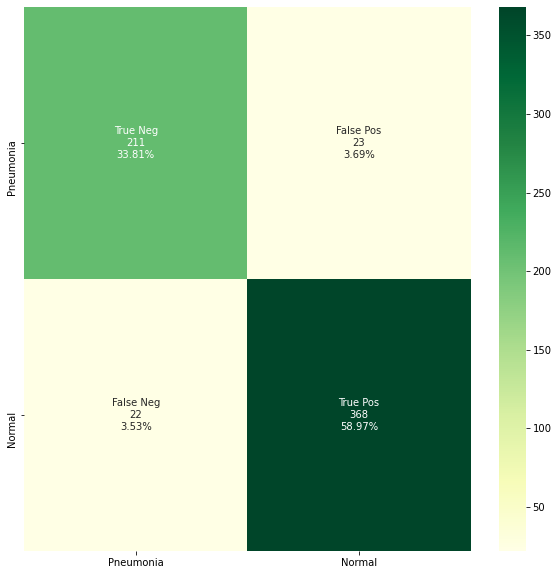

In [61]:
cf_matrix = confusion_matrix(y_test, pred_labelsRes)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

## Fine tuning the models

In [62]:
base_modelVG.trainable = True
base_modelRes.trainable = True

# Retrain the last 10 layers (all lower layers will be kept frozen)
for layer in base_modelVG.layers[:-10]:
    layer.trainable = False
    
for layer in base_modelRes.layers[:-10]:
    layer.trainable = False

Lower learning rates are generally better for fine-tuning pre-trained models because they require smaller adjustments to the weights to adapt to the new task.
https://www.mdpi.com/2076-3417/10/10/3359

In [63]:
model_pretrainedVG = get_pretrained(base_modelVG)
model_pretrainedVG.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001),
    metrics='binary_accuracy')

model_pretrainedRes = get_pretrained(base_modelRes)
model_pretrainedRes.compile(
    loss='binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001),
    metrics='binary_accuracy')

model_pretrainedVG.summary()
model_pretrainedRes.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 112, 112, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                           

In [64]:
history_ft = model_pretrainedVG.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction_two,early_stop_two],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )

Epoch 1/100
261/261 [==============================] - 15s 54ms/step - loss: 0.4710 - binary_accuracy: 0.8069 - val_loss: 0.2716 - val_binary_accuracy: 0.9121 - lr: 1.0000e-06
Epoch 2/100
261/261 [==============================] - 14s 53ms/step - loss: 0.2189 - binary_accuracy: 0.9130 - val_loss: 0.1684 - val_binary_accuracy: 0.9436 - lr: 1.0000e-06
Epoch 3/100
261/261 [==============================] - 15s 55ms/step - loss: 0.1716 - binary_accuracy: 0.9341 - val_loss: 0.1396 - val_binary_accuracy: 0.9436 - lr: 1.0000e-06
Epoch 4/100
261/261 [==============================] - 14s 54ms/step - loss: 0.1452 - binary_accuracy: 0.9407 - val_loss: 0.1426 - val_binary_accuracy: 0.9475 - lr: 1.0000e-06
Epoch 5/100
261/261 [==============================] - 16s 60ms/step - loss: 0.1345 - binary_accuracy: 0.9450 - val_loss: 0.1245 - val_binary_accuracy: 0.9503 - lr: 1.0000e-06
Epoch 6/100
261/261 [==============================] - 15s 56ms/step - loss: 0.1168 - binary_accuracy: 0.9558 - val_loss

261/261 [==============================] - 14s 53ms/step - loss: 0.0470 - binary_accuracy: 0.9826 - val_loss: 0.0678 - val_binary_accuracy: 0.9780 - lr: 1.0000e-06
Epoch 48/100
261/261 [==============================] - 14s 53ms/step - loss: 0.0473 - binary_accuracy: 0.9797 - val_loss: 0.0630 - val_binary_accuracy: 0.9752 - lr: 1.0000e-06
Epoch 49/100
261/261 [==============================] - 14s 54ms/step - loss: 0.0436 - binary_accuracy: 0.9845 - val_loss: 0.0766 - val_binary_accuracy: 0.9733 - lr: 1.0000e-06
Epoch 50/100
261/261 [==============================] - 14s 54ms/step - loss: 0.0486 - binary_accuracy: 0.9826 - val_loss: 0.0935 - val_binary_accuracy: 0.9694 - lr: 1.0000e-06
Epoch 51/100
261/261 [==============================] - 14s 53ms/step - loss: 0.0470 - binary_accuracy: 0.9806 - val_loss: 0.0759 - val_binary_accuracy: 0.9723 - lr: 1.0000e-06
Epoch 52/100
261/261 [==============================] - 14s 53ms/step - loss: 0.0374 - binary_accuracy: 0.9854 - val_loss: 0.049

In [65]:
history_ft = model_pretrainedRes.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction_two,early_stop_two],
                    steps_per_epoch = x_train.shape[0]/batch_size,
                    class_weight = class_weight
                   )

Epoch 1/100
261/261 [==============================] - 25s 66ms/step - loss: 0.7525 - binary_accuracy: 0.3398 - val_loss: 0.8600 - val_binary_accuracy: 0.4088 - lr: 1.0000e-06
Epoch 2/100
261/261 [==============================] - 15s 56ms/step - loss: 0.6353 - binary_accuracy: 0.4748 - val_loss: 0.7025 - val_binary_accuracy: 0.5396 - lr: 1.0000e-06
Epoch 3/100
261/261 [==============================] - 15s 58ms/step - loss: 0.5570 - binary_accuracy: 0.5995 - val_loss: 0.6341 - val_binary_accuracy: 0.6313 - lr: 1.0000e-06
Epoch 4/100
261/261 [==============================] - 14s 55ms/step - loss: 0.5028 - binary_accuracy: 0.6977 - val_loss: 0.5453 - val_binary_accuracy: 0.7077 - lr: 1.0000e-06
Epoch 5/100
261/261 [==============================] - 15s 57ms/step - loss: 0.4627 - binary_accuracy: 0.7462 - val_loss: 0.4895 - val_binary_accuracy: 0.7784 - lr: 1.0000e-06
Epoch 6/100
261/261 [==============================] - 14s 55ms/step - loss: 0.4282 - binary_accuracy: 0.7878 - val_loss

261/261 [==============================] - 15s 56ms/step - loss: 0.1952 - binary_accuracy: 0.9252 - val_loss: 0.1790 - val_binary_accuracy: 0.9370 - lr: 1.0000e-06
Epoch 48/100
261/261 [==============================] - 15s 56ms/step - loss: 0.1983 - binary_accuracy: 0.9254 - val_loss: 0.1777 - val_binary_accuracy: 0.9293 - lr: 1.0000e-06
Epoch 49/100
261/261 [==============================] - 15s 56ms/step - loss: 0.2018 - binary_accuracy: 0.9171 - val_loss: 0.1771 - val_binary_accuracy: 0.9417 - lr: 1.0000e-06
Epoch 50/100
261/261 [==============================] - 15s 56ms/step - loss: 0.2092 - binary_accuracy: 0.9188 - val_loss: 0.1733 - val_binary_accuracy: 0.9341 - lr: 1.0000e-06
Epoch 51/100
261/261 [==============================] - 15s 55ms/step - loss: 0.2010 - binary_accuracy: 0.9211 - val_loss: 0.1647 - val_binary_accuracy: 0.9398 - lr: 1.0000e-06
Epoch 52/100
261/261 [==============================] - 15s 56ms/step - loss: 0.1965 - binary_accuracy: 0.9240 - val_loss: 0.185

261/261 [==============================] - 15s 56ms/step - loss: 0.1547 - binary_accuracy: 0.9403 - val_loss: 0.1427 - val_binary_accuracy: 0.9513 - lr: 1.0000e-06
Epoch 94/100
261/261 [==============================] - 15s 56ms/step - loss: 0.1605 - binary_accuracy: 0.9372 - val_loss: 0.1525 - val_binary_accuracy: 0.9408 - lr: 1.0000e-06
Epoch 95/100
261/261 [==============================] - 15s 56ms/step - loss: 0.1604 - binary_accuracy: 0.9367 - val_loss: 0.1541 - val_binary_accuracy: 0.9436 - lr: 1.0000e-06
Epoch 96/100
261/261 [==============================] - 15s 56ms/step - loss: 0.1715 - binary_accuracy: 0.9307 - val_loss: 0.1397 - val_binary_accuracy: 0.9427 - lr: 1.0000e-06
Epoch 97/100
261/261 [==============================] - 15s 56ms/step - loss: 0.1592 - binary_accuracy: 0.9369 - val_loss: 0.1519 - val_binary_accuracy: 0.9360 - lr: 1.0000e-06
Epoch 98/100
261/261 [==============================] - 15s 56ms/step - loss: 0.1613 - binary_accuracy: 0.9355 - val_loss: 0.139

In [66]:
print("Loss of the tuned VG model is - " , model_pretrainedVG.evaluate(x_test,y_test)[0])
print("Accuracy of the tuned VG model is - " , model_pretrainedVG.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 51ms/step - loss: 0.1070 - binary_accuracy: 0.9615
Loss of the tuned VG model is -  0.1069905012845993
20/20 [==============================] - 1s 52ms/step - loss: 0.1070 - binary_accuracy: 0.9615
Accuracy of the tuned VG model is -  96.15384936332703 %


In [67]:
print("Loss of the tuned Res model is - " , model_pretrainedRes.evaluate(x_test,y_test)[0])
print("Accuracy of the tuned Res model is - " , model_pretrainedRes.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 70ms/step - loss: 0.1757 - binary_accuracy: 0.9311
Loss of the tuned Res model is -  0.17571578919887543
20/20 [==============================] - 1s 69ms/step - loss: 0.1757 - binary_accuracy: 0.9311
Accuracy of the tuned Res model is -  93.10897588729858 %


In [68]:
predictionsVG = model_pretrainedVG.predict(x_test)
pred_labelsVG= np.where(predictionsVG>0.5, 1, 0)

predictionsRes = model_pretrainedRes.predict(x_test)
pred_labelsRes= np.where(predictionsRes>0.5, 1, 0)

20/20 [==============================] - 4s 76ms/step


<AxesSubplot:>

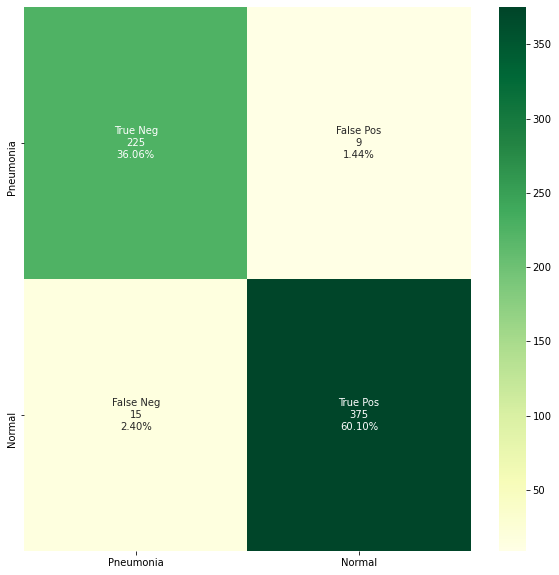

In [69]:
cf_matrix = confusion_matrix(y_test, pred_labelsVG)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

<AxesSubplot:>

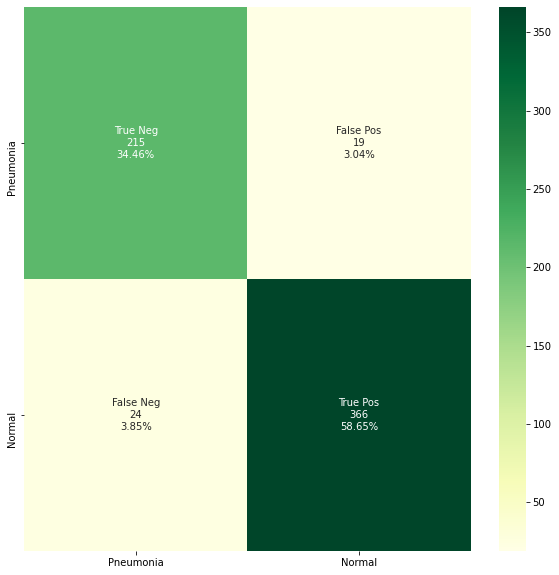

In [70]:
cf_matrix = confusion_matrix(y_test, pred_labelsRes)
plt.figure(figsize = (10,10))

labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn",
           xticklabels = classes,yticklabels = classes)

Overall both transfer learning models initially have lower accuracy than the baseline model, with ResNet coming out slightly on top, after fine tuning the models a statistically significant improvement is noted (>1%) for only one, while the other underperforms. The highest accuracy matches or beats out most models considered in the paper, but is still doesn't reach the highest accuracy that was achieved there. Future improvements could include removing the early stop function to maximize accuracy by disregarding time efficiency or combining different transfer learning models together instead of running and comparing them side by side.